In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ======================================================
# YOUR DATASET PATH (UNCHANGED)
# ======================================================
ROOT = Path(r'./data science bowl 2018/stage1_train 2')

CASE_DIRS = sorted([p for p in ROOT.iterdir() if p.is_dir()])
print(f"Total cases: {len(CASE_DIRS)}")

Total cases: 670


In [12]:
def load_case(case_dir):
    # Load grayscale image safely
    img_files = list((case_dir/'images').glob('*.png'))
    if len(img_files) == 0:
        return None, None   # prevents crash

    img = cv2.imread(str(img_files[0]), cv2.IMREAD_GRAYSCALE)

    # Combine all masks into single GT mask
    gt = np.zeros_like(img, np.uint8)
    for mp in (case_dir/'masks').glob('*.png'):
        m = cv2.imread(str(mp), 0)
        if m is not None:   # safety check
            gt = cv2.bitwise_or(gt, (m > 0).astype(np.uint8) * 255)

    return img, gt

In [14]:
# Convert results to dataframe
df = pd.DataFrame(rows)

# Show first few rows (optional)
display(df.head())

# Create summary comparison table
summary = pd.DataFrame({
    'Method': ['Without Marker Control', 'Marker-Controlled Watershed'],
    'Mean Pred Count': [df['wo_count'].mean(), df['mc_count'].mean()],
    'Mean Over-segmentation': [df['wo_over'].mean(), df['mc_over'].mean()],
    'Mean IoU (fg mask)': [df['wo_iou'].mean(), df['mc_iou'].mean()]
})

summary

,case,gt_count,wo_count,wo_over,wo_iou,mc_count,mc_over,mc_iou
0,003cee89357d9fe13516167fd67b609a164651b2193458...,34,35,1,0.910930,13,0,0.375870
1,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,40,13,0,0.058479,1,0,0.036929
2,0121d6759c5adb290c8e828fc882f37dfaf3663ec885c6...,64,6,0,0.003083,1,0,0.003874
3,01d44a26f6680c42ba94c9bc6339228579a95d0e2695b1...,6,2,0,0.008870,1,0,0.010721
4,0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc...,15,18,3,0.885489,9,0,0.737417


,Method,Mean Pred Count,Mean Over-segmentation,Mean IoU (fg mask)
0,Without Marker Control,55.045455,24.003497,0.650912
1,Marker-Controlled Watershed,9.652098,0.073427,0.338646


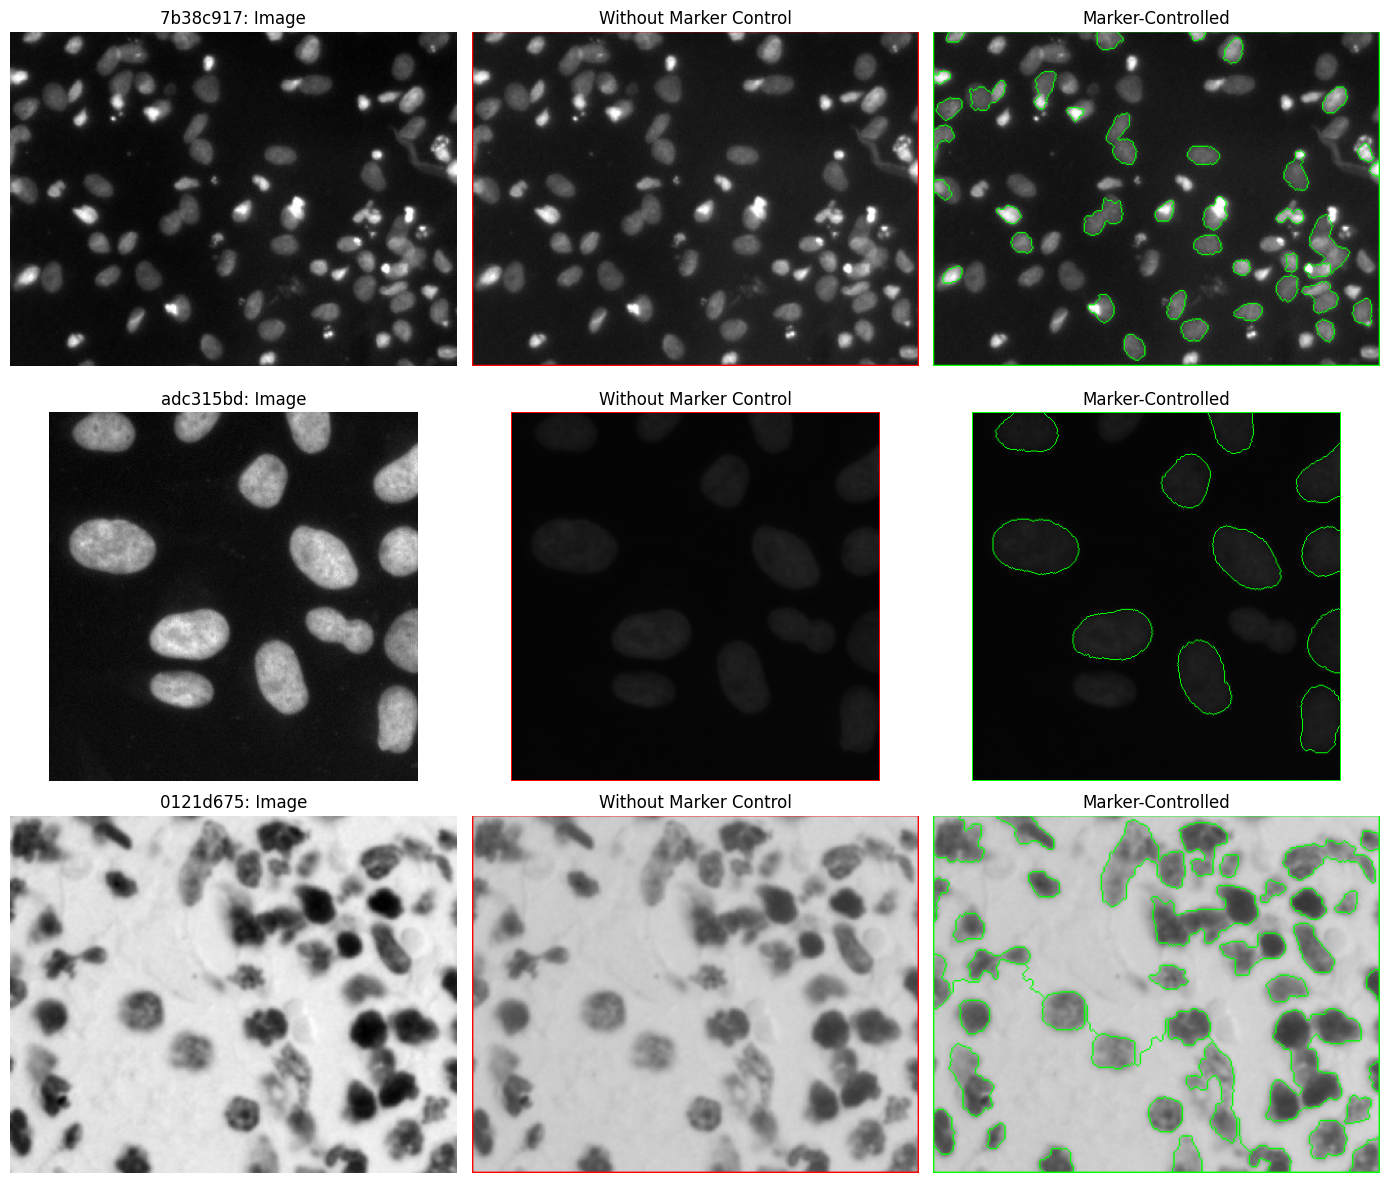

In [15]:
sample_cases = df.sort_values('mc_over', ascending=False).head(3)['case'].tolist()

plt.figure(figsize=(14, 12))

for i, cid in enumerate(sample_cases, 1):

    # make sure path is correct
    case_path = ROOT / cid

    img, gt = load_case(case_path)
    if img is None:
        continue

    pred_wo, ws_wo = watershed_without_markers(img)
    pred_mc, ws_mc = watershed_with_markers(img)

    # overlay watershed boundaries
    v1 = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    v1[ws_wo == -1] = [255, 0, 0]   # red boundary

    v2 = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    v2[ws_mc == -1] = [0, 255, 0]   # green boundary

    plt.subplot(3,3,3*i-2)
    plt.imshow(img, cmap='gray')
    plt.title(f'{cid[:8]}: Image')
    plt.axis('off')

    plt.subplot(3,3,3*i-1)
    plt.imshow(v1)
    plt.title('Without Marker Control')
    plt.axis('off')

    plt.subplot(3,3,3*i)
    plt.imshow(v2)
    plt.title('Marker-Controlled')
    plt.axis('off')

plt.tight_layout()
plt.show()